# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

### Подготовка данных

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -q /content/gdrive/MyDrive/dataset.zip

In [3]:
import numpy as np
import torch
import torchvision
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from pathlib import Path
from PIL import Image
from torchvision import transforms

# Сделано на основе class Carvana с семинара 6

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.root = data_dir
        self.transform = transform
        self.masks = list(sorted([x for x in Path(self.root).iterdir() if x.is_dir()]))
        self.images = []
        for path in self.masks:
          self.images += [x for x in Path(path).iterdir() if x.is_file()]
        self.images = list(sorted(self.images))

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        target = int(self.images[index].parent.name[6:])

        if self.transform is not None:
            # img = self.transform(img)
            img = self.transform(img)

        return (img, target)

    def __len__(self):
        return len(self.images)
    
def im_show(img_list):
  to_PIL = transforms.ToPILImage()
  if len(img_list) > 9:
      raise Exception('len(img_list) must be smaller than 10')

  for (idx, img) in enumerate(img_list):
      img = np.array(to_PIL(img))
      plt.figure(figsize=(4,4))
      fig = plt.imshow(img)
      fig.axes.get_xaxis().set_visible(False)
      fig.axes.get_yaxis().set_visible(False)
      plt.show()

In [38]:
from torchvision.transforms import Normalize, ToTensor, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAdjustSharpness, GaussianBlur
# (tensor([0.4802, 0.4481, 0.3975]), tensor([0.2770, 0.2691, 0.2821])) -- это я рассчитал ниже
train_transform = Compose([
                           RandomHorizontalFlip(p=0.5),
                           ColorJitter(brightness=0.2, contrast=0.2),
                           ToTensor(),
                           Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
                            ])
val_transform = Compose([
                         ToTensor(), 
                         Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
                         ])

train_dataset = MyDataset("./dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("./dataset/dataset/val", transform=val_transform)

In [5]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


Посмотрим на применяемые аугментации

In [6]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Взято из документации библиотеки Albumentations и немного переделано
def visualize(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = Compose([t for t in dataset.transform.transforms if not isinstance(t, (Normalize, ToTensor))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

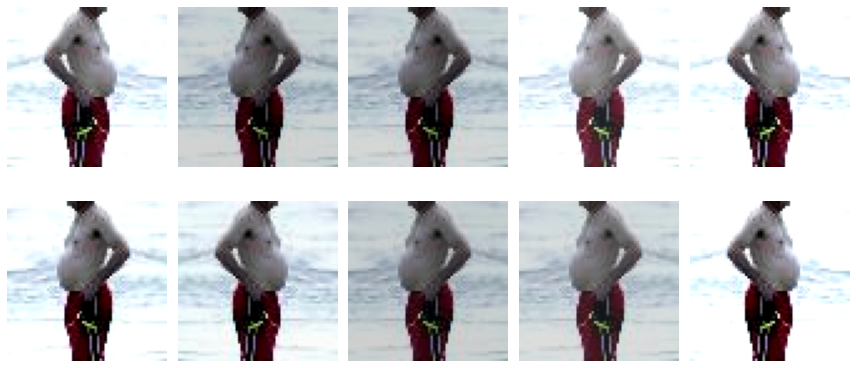

In [52]:
visualize(train_dataset, 3021)

А вот так изображение будет выглядеть после нормализации

6 3021


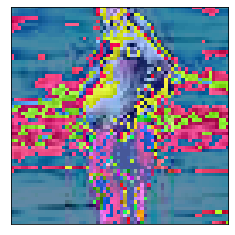

In [53]:
idx = 3021
img, label = train_dataset[idx]
print(label, idx)
im_show([img])

### Вспомогательные функции, реализация модели

In [10]:
def plot_metrics(train_metrics, test_metrics, mtype, n_epochs=10):
    plt.figure(figsize=(12, 6))
    plt.plot(train_metrics, label="train")
    plt.plot(test_metrics, label="test")
    plt.legend(loc='best')
    plt.xlabel("epoch")
    plt.ylabel(mtype)
    plt.xlim((0, n_epochs))
    if mtype == 'accuracy':
        plt.ylim((0, 0.8))
    else:
        plt.ylim((0, 6))
    plt.grid()
    plt.show()

In [11]:
from IPython.display import clear_output

In [12]:
# на основе семинара 5
def train_one_epoch(model, dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(dataloader)) as prbar:
        for images, labels in dataloader:
            # Move Batch to GPU
            images, labels = images.to(device), labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {
        'loss': total_loss / num_batches,
        'accuracy': accuracy_score(total_labels, total_predictions),
    }
    return metrics, all_losses


def predict(model, dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()
    losses, predicted_classes, true_classes = np.array([]), np.array([]), np.array([])
    with tqdm(total=len(dataloader)) as prbar:
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            losses = np.append(losses, loss.item())
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, n_epochs, scheduler=None, device="cuda:0"):
    epoch_train_accuracy = []
    epoch_test_accuracy = []
    epoch_train_loss = []
    epoch_test_loss = []
    for epoch in range(n_epochs):
        # train
        print(f'Train Epoch: {epoch}')
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        if scheduler:
            scheduler.step()
        epoch_train_loss.append(train_metrics['loss'])
        epoch_train_accuracy.append(train_metrics['accuracy'])

        # eval
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            test_losses, predicted_classes, true_classes = predict(
                model=model,
                dataloader=val_dataloader,
                criterion=criterion,
                device=device
            )
        test_loss = np.mean(test_losses)
        epoch_test_loss.append(test_loss)

        test_accuracy = accuracy_score(true_classes, predicted_classes)
        epoch_test_accuracy.append(test_accuracy)

        clear_output()
        plot_metrics(epoch_train_accuracy, epoch_test_accuracy, 'accuracy', n_epochs)
        plot_metrics(epoch_train_loss, epoch_test_loss, 'loss', n_epochs)
        print(
            f"Epoch {epoch}\n",
            f"train: Loss: {train_metrics['loss']:.4f}  Accuracy: {train_metrics['accuracy']:.4f}\n",
            f"validation: Loss: {test_loss:.4f}  Accuracy: {test_accuracy:.4f}"
        )

### Обучение модели, запуски экспериментов

In [13]:
import random
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [14]:
set_random_seed(3021)

In [15]:
from torchvision.models import resnet18

In [42]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 200)

In [54]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

In [43]:
model = model
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256,
                                          shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256,
                                         shuffle=False)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=6)
n_epochs = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Подсчет среднего и стандартного отклонения для наших данных:

In [37]:
# Взято отсюда https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
get_mean_and_std(train_dataloader)

(tensor([0.4802, 0.4481, 0.3975]), tensor([0.2770, 0.2691, 0.2821]))

Простой тест на проверку правильности написанного кода

In [30]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.6373 Accuracy: 0.0: 100%|██████████| 40/40 [00:10<00:00,  3.65it/s]

tests passed


Запустить обучение можно в ячейке ниже.

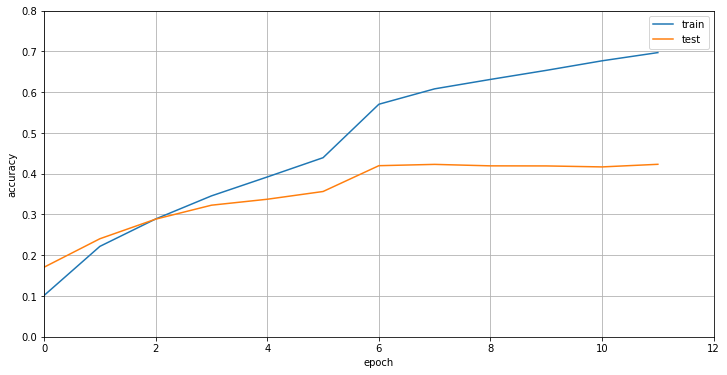

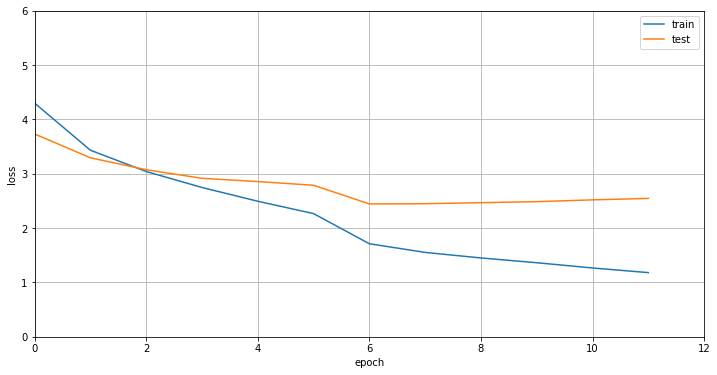

Epoch 11
 train: Loss: 1.1808  Accuracy: 0.6971
 validation: Loss: 2.5459  Accuracy: 0.4231


In [44]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, n_epochs, scheduler, device)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [45]:
def evaluate(model, val_dataloader, criterion, device):
    all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
    assert len(predicted_labels) == len(val_dataset)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

In [47]:
total_accuracy = evaluate(model, val_dataloader, criterion, device

Loss: 1.5127 Accuracy: 0.75: 100%|██████████| 40/40 [00:11<00:00,  3.63it/s]


In [51]:
print("Оценка за первое задание составит {:2.1f} баллов".format(min(10, 10 * total_accuracy / 0.44)))

Оценка за первое задание составит 9.6 баллов


### Отчёт об экспериментах

Для выполнения задания я сразу выбрал модель Resnet18. Также после пары экспериментов мною было принято решение вместо SGD Momentum использовать Adam (а позже и AdamW для снижения переобучения, а оно у меня здесь сильнейшее😅)

**Модели для скриншотов я все обучал на 5-ти эпохах (кроме финальной) для экономии времени**

Для начала я попробовал не использовать никакие аугментации, а лишь нормализовать изображения:


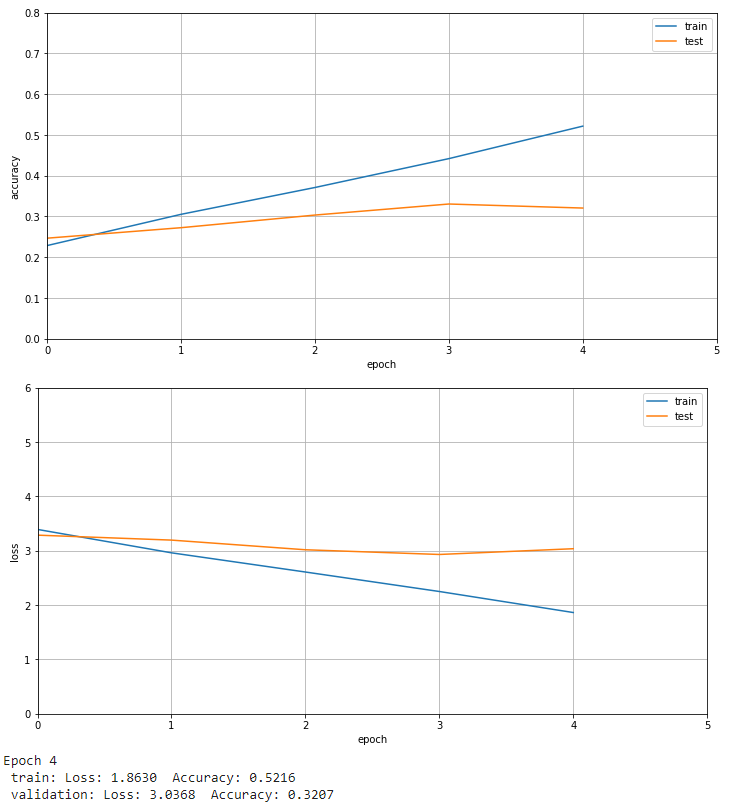

Пока что результат неутешительный: во первых почти сразу мы вышли на плато на тесте, достигнув не очень высокого результата. При этом еще и получили переобучение модели, так как accuracy на трейне продолжал стабильно расти (loss падать).

Далее я подсчитал среднее и стандартное отклонение конкретно для наших данных, чтобы провести нормализацию более корректно и получил следующее:

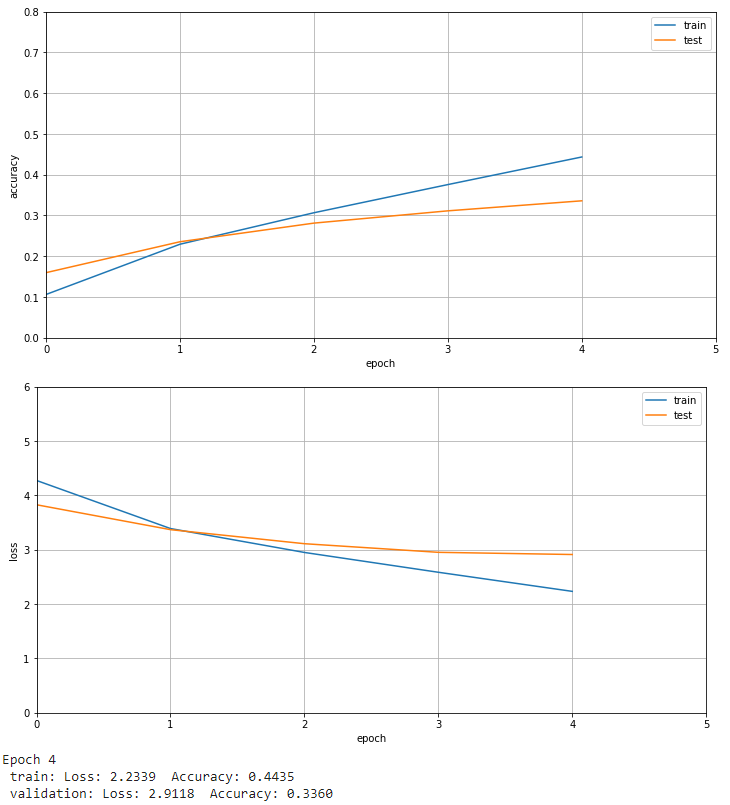

Как можем видеть, это принесло пользу -- accuracy на тесте немного подрос, а еще мы снизили переобучение.

Затем я добавил парочку аугментаций -- отражение картинок относительно вертикальной оси и изменение яркости и контрастности:

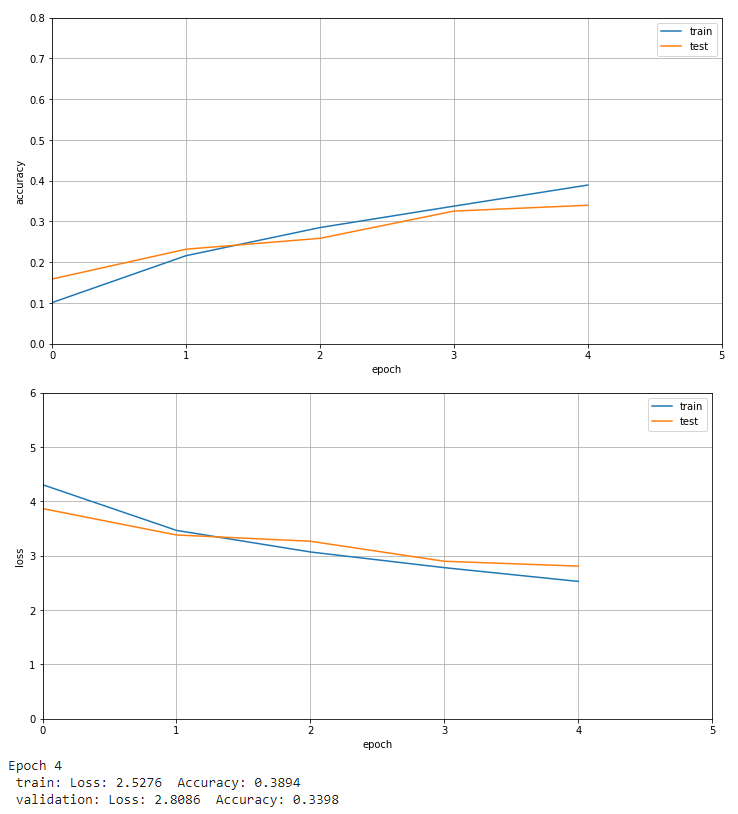

Снизили переобучение еще сильнее! + немного прибавили в качестве

Закончились мои эксперименты добавление шедулера, что очень существенно помогло мне прибавить в accuracy (его я установил на основе графиков выше, там уже на пятой эпохе можно наблюдать возникновение плато, поэтому я решил включить его на 6-ой эпохе):

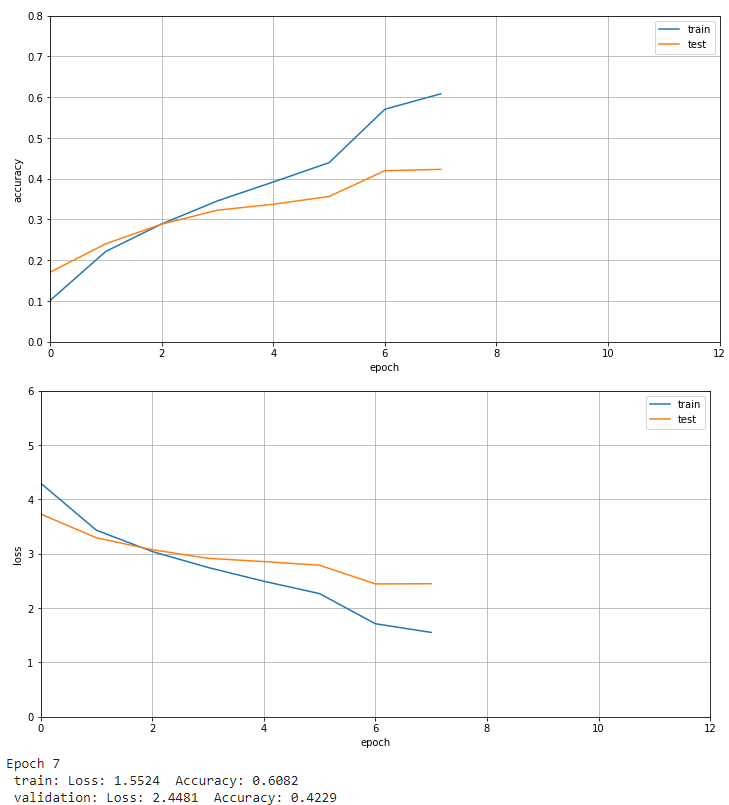

В результате имеем колоссальный прирост в accuracy и падение loss'а, а также колоссальное переобучение🤪 Но поскольку моей задачей было достичь определенного порога accuracy на тестовых данных, то забьем на то, что мы так переобучили модель, ведь цели мы достигли!